## Finalizado!!

# Building local agent using LangGraph, LLaMA3 and Chroma vector store

- Adaptive RAG for Routing: Which directs questions to a vector store or web search based on the content https://arxiv.org/abs/2403.14403
- Corrective RAG for Fallback: Using this we will introduce a Fallback retrival where if a question isn't relevant to the vector store, we will use a web-search instead. https://arxiv.org/pdf/2401.15884
- Self RAG for Self Correction: Additonally, we will add self-correction to check generations for hallucinations and relevance, and if they're not suitable, we'll fallback to web search again. https://arxiv.org/abs/2310.11511

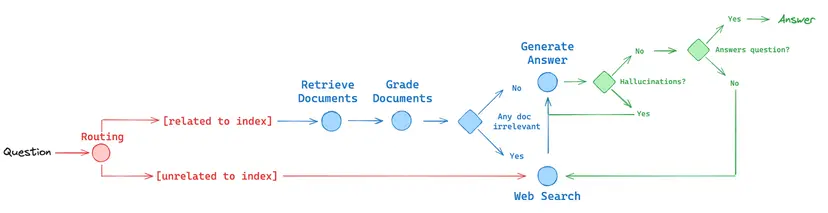

In [1]:
%pip install -r requirements.txt

  Using cached langchainhub-0.1.21-py3-none-any.whl.metadata (659 bytes)
  Using cached lark-1.2.2-py3-none-any.whl.metadata (1.8 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached langchain_nomic-0.1.4-py3-none-any.whl.metadata (1.6 kB)
  Using cached tavily_python-0.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached gpt4all-2.8.2-py3-none-win_amd64.whl.metadata (4.8 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with s

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
crewai 0.86.0 requires chromadb>=0.5.18, but you have chromadb 0.5.0 which is incompatible.
embedchain 0.1.126 requires chromadb<0.6.0,>=0.5.10, but you have chromadb 0.5.0 which is incompatible.
embedchain 0.1.126 requires langchain-openai<0.3.0,>=0.2.1, but you have langchain-openai 0.3.2 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
grpcio-tools 1.68.1 requires grpcio>=1.68.1, but you have grpcio 1.67.1 which is incompatible.
litellm 1.56.3 requires httpx<0.28.0,>=0.23.0, but you have httpx 0.28.1 which is incompatible.


In [2]:
%pip install --upgrade --quiet  semanticscholar langchain-google-community

Note: you may need to restart the kernel to use updated packages.


In [3]:
! pip install langchain-ollama "ollama==0.4.2" colab-xterm -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.126 requires chromadb<0.6.0,>=0.5.10, but you have chromadb 0.5.0 which is incompatible.
embedchain 0.1.126 requires langchain-openai<0.3.0,>=0.2.1, but you have langchain-openai 0.3.2 which is incompatible.
langchain-google-vertexai 2.0.12 requires httpx<0.29.0,>=0.28.0, but you have httpx 0.27.2 which is incompatible.


In [4]:

from langchain_community.document_loaders import WebBaseLoader
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_elasticsearch import ElasticsearchStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
import chromadb
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain_chroma import Chroma

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [10]:
from dotenv import load_dotenv
load_dotenv()

# Access the API key
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
# os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
# os.environ["GOOGLE_CSE_ID"] = userdata.get("GOOGLE_CSE_ID")
# LLM
local_llm = "llama3:8b"

In [11]:
def load_file(path):
    # load pdf file and transform into Langchain Documents
    loader = PyPDFLoader(path)
    pages = loader.load_and_split()
    return pages

In [28]:
mypath = ".\data"

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\athos\AppData\Local\Temp\ipykernel_18724\4137451204.py:1: SyntaxWarning: invalid escape sequence '\d'
  mypath = ".\data"


In [29]:
embeddings=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")

In [30]:
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
onlyfiles

['BOE-A-2000-323-consolidado.pdf']

In [31]:
# add documents to Chroma
docs= []
for file in onlyfiles:
    path = os.path.join(mypath, file)
    pages = load_file(path)
    print(f" Loaded file {file} with {len(pages)} ")
    docs.extend(pages)

 Loaded file BOE-A-2000-323-consolidado.pdf with 534 


In [32]:
docs[0]

Document(metadata={'source': '.\\data\\BOE-A-2000-323-consolidado.pdf', 'page': 0, 'page_label': '1'}, page_content='Ley 1/2000, de 7 de enero, de Enjuiciamiento Civil.\nJefatura del Estado\n«BOE» núm. 7, de 08 de enero de 2000\nReferencia: BOE-A-2000-323\nÍNDICE\n   \nPreámbulo ................................................................... 8\nTÍTULO PRELIMINAR. De las normas procesales y su aplicación................................ 39\nLIBRO I. De las disposiciones generales relativas a los juicios civiles.............................. 40\nTÍTULO I. De la comparecencia y actuación en juicio ...................................... 40\nCAPÍTULO I. De la capacidad para ser parte, la capacidad procesal y la legitimación ................ 40\nCAPÍTULO II. De la pluralidad de partes............................................. 43\nCAPÍTULO III. De la sucesión procesal ............................................. 46\nCAPÍTULO IV. Del poder de disposición de las partes sobre el proceso y

In [33]:
len(docs)

534

In [34]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs)
documents=doc_splits

In [35]:
len(documents)

2352

In [36]:
path_chroma =".\data\chroma"

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\athos\AppData\Local\Temp\ipykernel_18724\1866834848.py:1: SyntaxWarning: invalid escape sequence '\d'
  path_chroma =".\data\chroma"


# Create Vector db or Load from disk

In [45]:
db = Chroma.from_documents(documents=documents, embedding=embeddings, persist_directory=path_chroma)

Embedding texts: 100%|██████████| 2352/2352 [24:00<00:00,  1.63inputs/s]


In [ ]:
# db = Chroma(persist_directory=path_chroma, embedding_function=embeddings)

In [50]:
retriever = db.as_retriever()

In [51]:
db.similarity_search_with_score("articulo 1")

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 28.96inputs/s]


[(Document(id='77b63262-813e-4dea-981c-6766cbb33bd3', metadata={'page': 317, 'page_label': '318', 'source': '.\\data\\BOE-A-2000-323-consolidado.pdf'}, page_content='Artículo 815.  Admisión de la petición y requerimiento de pago.\n1. Si los documentos aportados con la petición fueran de los previstos en el apartado 2 \ndel artículo 812 o constituyeren un principio de prueba del derecho del peticionario, \nconfirmado por lo que se exponga en aquella, el letrado o letrada de la Administración de \nJusticia requerirá al deudor para que, en el plazo de veinte días, pague al peticionario, \nacreditándolo ante el tribunal, o comparezca ante éste y alegue de forma fundada y \nmotivada, en escrito de oposición, las razones por las que, a su entender, no debe, en todo o \nen parte, la cantidad reclamada. En caso contrario dará cuenta al juez o jueza para que'),
  0.7070164084434509),
 (Document(id='d43f632c-c0eb-4a54-8f21-000db865d12d', metadata={'page': 128, 'page_label': '129', 'source': '.\\

# Grader
Once we index our respective documents into the data store will need to create a grader that evaluates the relevance of our retrieved document to a given user question. Now this is where llama3 comes in, I set my local_llm to llama3 and llama has "json" mode which confirm the output from LLM is also json, so my prompt basically says grade a document and return a json with score yes/no


In [52]:
# Retrieval Grader

from langchain_ollama import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "indemnizacion del daño corporal"
docs = retriever.invoke(question)

# First check if any documents were retrieved
if not docs:
    print("No documents retrieved")
else:
    # Use the first document (index 0)
    doc_txt = docs[0].page_content
    print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 28.97inputs/s]


{'score': 'yes'}


In [53]:
print(f"numeros de retrieved docs: {len(docs)}")


numeros de retrieved docs: 4


In [54]:
retrieval_grader = prompt | llm | JsonOutputParser()
question = "Que es el kikuchi?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 29.41inputs/s]


{'score': 'no'}


# Generator
Generate a concise answer to user's question using context from retrieved documents.


In [55]:
# Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
import pprint
# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question}
    Context: {context}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

llm = ChatOllama(model=local_llm, temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "indemnizacion del daño corporal"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
pprint.pprint(generation)


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 34.49inputs/s]


("I don't know the answer to your question based on the provided context. The "
 'documents appear to be related to Spanish law and procedures for liquidating '
 "damages and perjuicios, but I couldn't find any specific information on "
 'indemnización del daño corporal (corporal damage compensation). If you '
 'provide more context or clarify what you mean by "indemnización del daño '
 'corporal", I may be able to help further.')


# Hallucination Grader and Answer Grader
defines two separate graders—one for assessing hallucination in a generated answer and another for evaluating the usefulness of the answer in resolving a question. Both graders use a language model (LLM) to provide binary scores ("yes" or "no") based on specific criteria

In [56]:
# Hallucination Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents}
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hg = hallucination_grader.invoke({"documents": docs, "generation": generation})

### Answer Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation}
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
ag = answer_grader.invoke({"question": question, "generation": generation})


print(f" Hallucination Grader: {hg}, Answer Grader: {ag}")

 Hallucination Grader: {'score': 'no'}, Answer Grader: {'score': 'yes'}


#Router
"Router" system designed to determine whether a user’s question should be directed to a vectorstore or a web search for further information retrieval

In [57]:
# Router

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing, route to the vectorstore any legal related question.
     Otherwise, use web-search. Give a binary choice 'web_search' or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and
    no premable or explanation. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "En que fecha se aprobo la ley de enjuiciamiento civil?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))


C:\Users\athos\AppData\Local\Temp\ipykernel_18724\449912768.py:8: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model=local_llm, format="json", temperature=0)
C:\Users\athos\AppData\Local\Temp\ipykernel_18724\449912768.py:19: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)
Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 14.47inputs/s]


{'datasource': 'vectorstore'}


In [58]:

question_router = prompt | llm | JsonOutputParser()
question = "que es el la enfermedad del kikuchi?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 13.00inputs/s]


{'datasource': 'web_search'}


# Web Search
The code sets up a web search tool that can be used to query the web and retrieve a limited number of search results (in this case, 3). This is useful in scenarios where you want to integrate external web search capabilities into a system, enabling it to fetch information from the internet and use that information for further processing or decision-making

In [59]:
# Search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)


# Control Flow
graph-based workflow for processing user queries. It retrieves documents, generates answers, grades relevance, and routes the process based on the current state. This system is highly modular, allowing each step in the process to be independently defined and controlled, making it flexible and scalable for various use cases involving document retrieval, question answering, and ensuring the quality and relevance of generated content

In [60]:
from pprint import pprint
from typing import List

import time

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph

# State


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]


# Nodes


def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}


# Conditional edge


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


# Conditional edge


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae


# Build Graph

It determines how the process should move from one node (operation) to the next based on the conditions and results at each step.

- The workflow starts by deciding whether to retrieve documents from a vectorstore or perform a web search based on the user's question.
- then assesses the relevance of the retrieved documents, deciding whether to generate an answer or conduct further web searches if the documents aren't relevant.
- Finally, it generates an answer and checks whether it is well-supported and useful, repeating steps or ending the workflow based on the outcome.

In [61]:
# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)


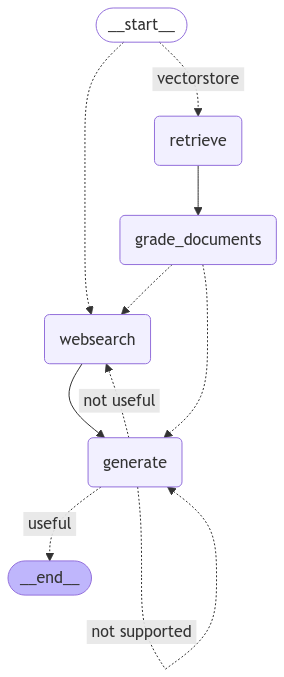

In [62]:
from IPython.display import Image, display

app = workflow.compile()
display(Image(app.get_graph(xray=1).draw_mermaid_png()))

In [63]:
from pprint import pprint

inputs = {"question": "En que fecha se aprobo la ley de enjuiciamiento civil y principal proposito de la ley"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
En que fecha se aprobo la ley de enjuiciamiento civil y principal proposito de la ley
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 15.62inputs/s]

'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---


---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('The Ley de Enjuiciamiento Civil was approved on January 7, 2000. The main '
 'purpose of the law is to regulate the fundamental aspects of civil procedure '
 'and ensure that laws are executed by a court in a fair and efficient manner.')


In [64]:
from pprint import pprint

# Compile
app = workflow.compile()
inputs = {"question": "what is kikuchi?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
what is kikuchi?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 32.23inputs/s]

'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---


---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Kikuchi refers to Kikuchi-Fujimoto disease or Kikuchi histiocytic '
 'necrotizing lymphadenitis, a rare and benign condition characterized by '
 'cervical lymphadenopathy and fever. It is often mistaken for other '
 'conditions such as lymphoma, systemic lupus erythematosus, tuberculosis, or '
 'adenocarcinoma. The condition typically affects the cervical lymph nodes and '
 'is self-limiting, meaning it resolves on its own without treatment.')
